In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, IntersectionDataset, stack_samples, unbind_samples, random_bbox_assignment
from torchgeo.samplers import RandomGeoSampler, RandomBatchGeoSampler, GridGeoSampler
from torchgeo.datamodules import GeoDataModule
import rasterio
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# MLP Approach
Here we implement a multilayer perceptron to start exploring the provided segmentation datasets and also to have a first approach to segmentation.

Reference projs, docs & papers:
* [Paper] [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/abs/1411.4038)
* [Web] [A complete guide to semantic segmentation in 2024](https://nanonets.com/blog/semantic-image-segmentation-2020/)


**NOTE:**
> For this delivery, we are not supposed to use convolutional networks, hence we will extract some ideas from the paper listed above, but in the end we will just have a multilayer perceptron.

In [2]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


## Image Loader

In [3]:
dataset_path = './datasets/Inria/AerialImageDataset/train'
# test_path = './datasets/Inria/AerialImageDataset/test'

In [4]:
x = rasterio.open(os.path.join(dataset_path, 'images/austin1.tif'))
x = x.read()
print(x.shape) # (channels, rows, cols)

(3, 5000, 5000)


In [5]:
y = rasterio.open(os.path.join(dataset_path, 'gt/austin1.tif'))
y = y.read()
print(y.shape)

(1, 5000, 5000)


In this case:
* Input: Patches of 5000x5000x3 (3 channels - RGB)
* Output: Patches of 5000x5000x1 (1 channel - segmentation map)

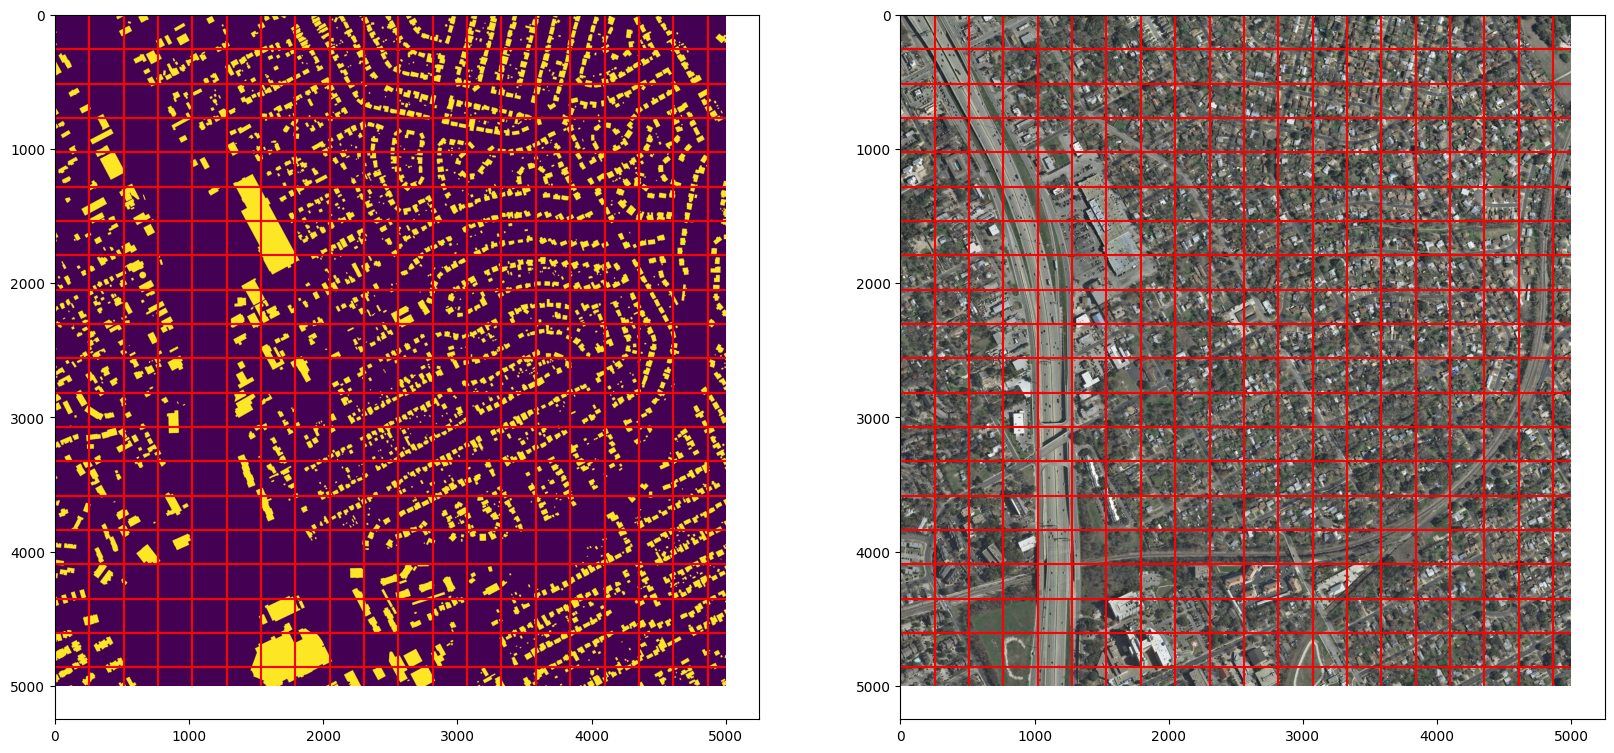

In [6]:
def plot_tiles(ax, tile_size, h, w):
  ax.vlines(list(range(0, h, tile_size)), 0, w, color='red')
  ax.hlines(list(range(0, w, tile_size)), 0, h, color='red')

tile_size = 256

fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(y.T)
plot_tiles(axs[0], tile_size, y.shape[1], y.shape[2])

axs[1].imshow(x.T)
plot_tiles(axs[1], tile_size, x.shape[1], x.shape[2])
plt.show()


**Torchgeo Dataset**

In [7]:
def plot_images(base_plot_size=4, **images):
  n = len(images)
  siz = base_plot_size * n
  fig, axs = plt.subplots(1,n, figsize=(siz, base_plot_size))

  for i, (name, image) in enumerate(images.items()):
    if n > 1:
      axs[i].set_title(name)
      axs[i].imshow(image)
      axs[i].axis('off')
    else:
      axs.set_title(name)
      axs.imshow(image)
  plt.tight_layout()

In [8]:
class RGBLoader(RasterDataset):
  filename_glob = '*.tif'
  is_image=True
  separate_files=False
  # all_bands=('B01', 'B02', 'B03')
  # rgb_bands=('B01', 'B02', 'B03')

class SegmentationMapLoader(RasterDataset):
  filename_glob = '*.tif'
  is_image=False # False means is a segmentation mask
  dtype=torch.float32 # Override to be used in pixel-wise regression
  separate_files=False

In [9]:
def transform_image(x, kernels):
  image = x['image']
  if len(image.shape) < 3: 
    image = image.unsqueeze(0)
  
  result = [image.squeeze()] # Instead of doing processing with identity kernel

  for k in kernels:
    out = F.conv2d(image, torch.tensor([[k], [k], [k]], dtype=torch.float32), groups=3, padding=1)
    
    result.append(out.squeeze())
  result = torch.concat(result)
  
  return {**x, 'image': result}

Testing kernels & create dataloaders

In [10]:
# Read:
# https://setosa.io/ev/image-kernels/
# https://www.geeksforgeeks.org/types-of-convolution-kernels/#2-edge-detection-kernels

# # Identity
# k1 = [
#   [0, 0, 0],
#   [0, 1, 0],
#   [0, 0, 0]
# ]

# Emboss
k2 = [
  [-2, -1, 0],
  [-1, 1, 1],
  [0, 1, 2]
]

# Edge Detection (Outline)
k3 = [
  [-1, -1, -1],
  [-1, 8, -1],
  [-1, -1, -1]
]

kernels = [k2, k3]

In [11]:
segmentation_transforms = v2.Compose([
  v2.Resize(size=64),
])

images_dataset = RGBLoader(os.path.join(dataset_path, 'images/'), transforms=lambda x: transform_image(x, kernels))
segmentation_map_dataset = SegmentationMapLoader(os.path.join(dataset_path, 'gt/'), transforms=segmentation_transforms)
dataset = images_dataset & segmentation_map_dataset # Intersection Dataset

print(images_dataset)
print(segmentation_map_dataset)
print(dataset)

Converting SegmentationMapLoader res from 0.3 to 0.29999999999997673
RGBLoader Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=-1281274.2289648592, maxx=5353879.269352471, miny=3343499.9999999995, maxy=12340611.831173468, mint=0.0, maxt=9.223372036854776e+18)
    size: 180
SegmentationMapLoader Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=-1281274.2289648592, maxx=5353879.269352471, miny=3343500.0, maxy=12340611.831173468, mint=0.0, maxt=9.223372036854776e+18)
    size: 180
IntersectionDataset Dataset
    type: IntersectionDataset
    bbox: BoundingBox(minx=-1281274.2289648592, maxx=5353879.269352471, miny=3343500.0, maxy=12340611.831173468, mint=0.0, maxt=9.223372036854776e+18)
    size: 804


/Users/edwmapa/anaconda3/envs/mlenv_nn/lib/python3.11/site-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


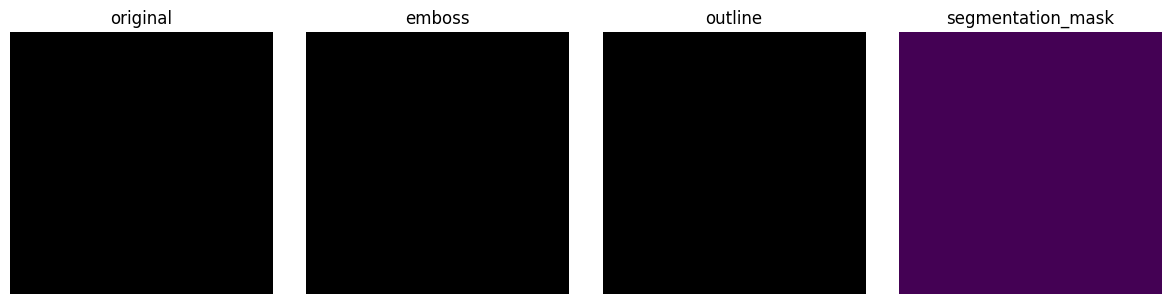

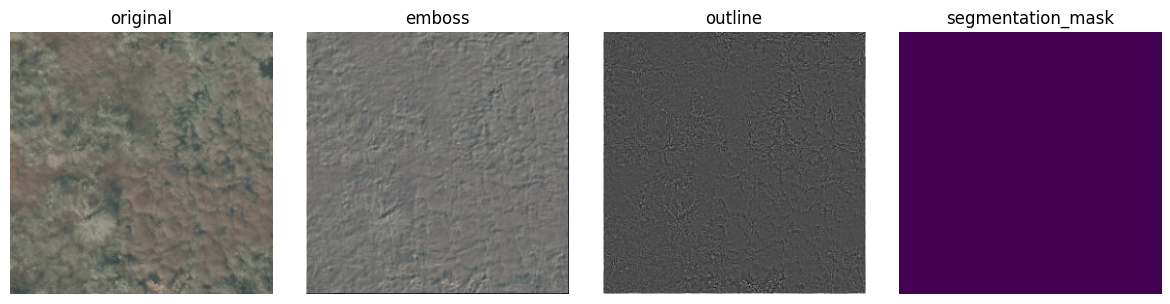

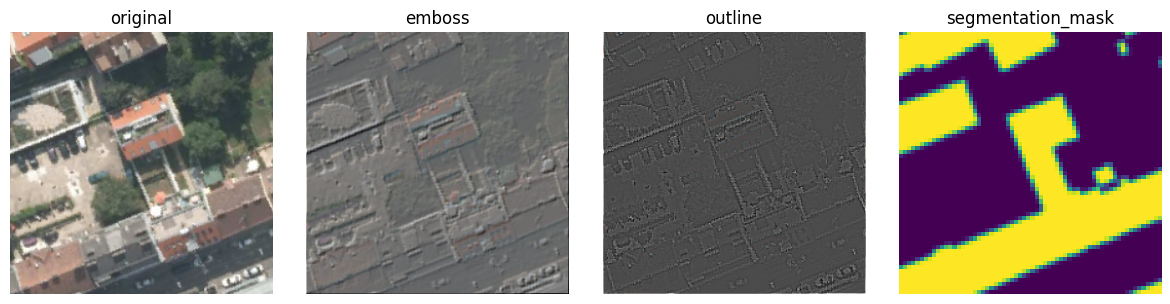

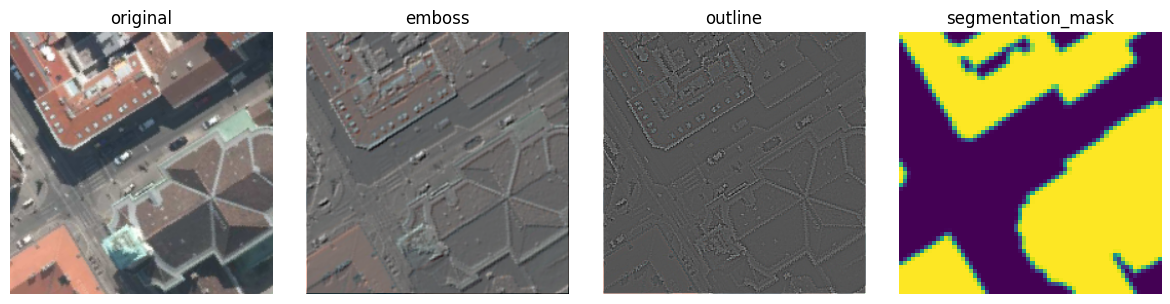

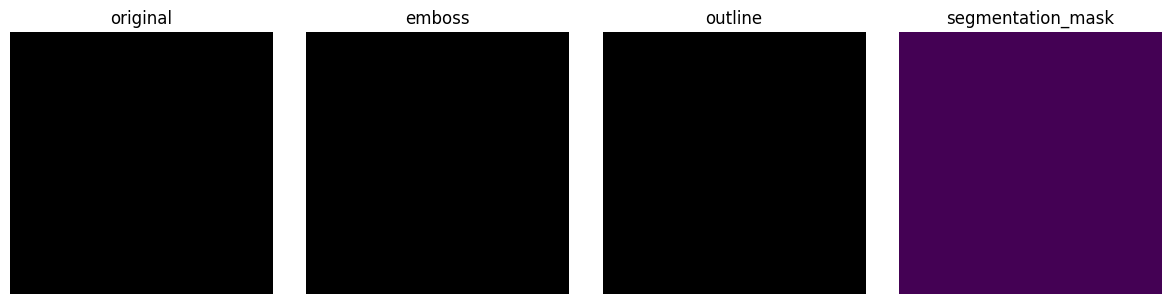

In [12]:
sampler = RandomGeoSampler(dataset, size=256, length=10)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

n=0
for sample in dataloader:
  if n==5: break
  
  image, gt = sample['image'], sample['mask']

  image_original = image.squeeze()[:3]/255 #k1

  image_emboss = image.squeeze()[3:6]/255 #k2
  _min, _max = torch.aminmax(image_emboss)
  image_emboss = (image_emboss - _min) / (_max - _min)

  image_outline = image.squeeze()[6:9]/255 #k3
  _min, _max = torch.aminmax(image_outline)
  image_outline = (image_outline - _min) / (_max - _min)


  plot_images(
    base_plot_size=3,
    original=v2.ToPILImage(mode='RGB')(image_original),
    emboss=v2.ToPILImage(mode='RGB')(image_emboss),
    outline=v2.ToPILImage(mode='RGB')(image_outline),
    segmentation_mask=gt.squeeze()/255
  )
  n+=1

**Dataset split (train/test) and DataLoader**
> Note: In the end, we didn't use this, instead used Lighthing DataModules

In [13]:
# Get count per city from train folder
# (keep in mind that test does not have the ground truth, so we will do a 80/20 split over the train folder)

filenames = os.listdir(os.path.join(dataset_path, 'gt'))
train_filenames, test_filenames = train_test_split(filenames, test_size=0.2, random_state=1234)
train_test_filenames = [train_filenames, test_filenames]


# Copy to split_dataset folder (actually, it creates symlinks)
train_path = './datasets/Inria/AerialImageDataset/split_dataset/train/'
test_path = './datasets/Inria/AerialImageDataset/split_dataset/test/'
train_test_paths = [train_path, test_path]

for path, files in zip(train_test_paths, train_test_filenames):
  shutil.rmtree(path, ignore_errors=True)
  os.makedirs(os.path.join(path, 'images'), exist_ok=True)
  os.makedirs(os.path.join(path, 'gt'), exist_ok=True)

  for file in files:
    src = os.path.abspath(os.path.join(dataset_path, 'images', file))
    dst = os.path.abspath(os.path.join(path, 'images', file))
    os.symlink(src, dst)

    src = os.path.abspath(os.path.join(dataset_path, 'gt', file))
    dst = os.path.abspath(os.path.join(path, 'gt', file))
    os.symlink(src, dst)

print("# images:", len(filenames))
print(f"Split: (train = {len(train_filenames)}, test = {len(test_filenames)})")


# images: 180
Split: (train = 144, test = 36)


In [14]:
img_size = 256
sample_size = 500
batch_size = 32

train_dataset = RGBLoader(os.path.join(train_path, 'images/')) & SegmentationMapLoader(os.path.join(train_path, 'gt/'))
test_dataset = RGBLoader(os.path.join(test_path, 'images/')) & SegmentationMapLoader(os.path.join(test_path, 'gt/'))

train_dataloader = DataLoader(
  train_dataset,
  batch_size=batch_size,
  sampler=RandomGeoSampler(train_dataset, size=img_size, length=sample_size), # random sampling
  collate_fn=stack_samples,
)

test_dataloader = DataLoader(
  test_dataset,
  batch_size=32,
  sampler=RandomGeoSampler(test_dataset, size=img_size, length=sample_size),
  collate_fn=stack_samples,
)

Converting SegmentationMapLoader res from 0.3 to 0.29999999999997673
Converting SegmentationMapLoader res from 0.3 to 0.29999999999997673


## Model


Samplers & data loaders:
* https://torchgeo.readthedocs.io/en/stable/tutorials/custom_raster_dataset.html
* https://torchgeo.readthedocs.io/en/latest/api/datasets.html#torchgeo.datasets.IntersectionDataset
* https://torchgeo.readthedocs.io/en/stable/api/samplers.html

Loses:
* https://torchgeo.readthedocs.io/en/latest/api/losses.html

Ref:
* https://www.kaggle.com/code/luizclaudioandrade/semantic-segmentation-torchgeo


**NOTE:**
> As stated at the beggining of the notebook, we will build the model as a MLP

**Defnining DataModule (lightning)**

*Better use data modules to handle the whole process, and handle train/test/validate split from there*

In [15]:
class CustomGeoDataModule(GeoDataModule): # Geodamatodule extends from torch lightning DataModules
  def __init__(self, **kwargs):
    super().__init__(
      dataset_class=kwargs['dataset_class'],
      batch_size=kwargs['batch_size'],
      patch_size=kwargs['patch_size'],
      length=kwargs['length'],
      num_workers=kwargs['num_workers'],
      **kwargs['dataset_class_kwargs']
    )
    # keep in mind that super method will set kwargs object attribute as kwargs['dataset_class_kwargs']
    self.split_faction = kwargs.get('split_fraction', [0.6, 0.2, 0.2])

  def setup(self, stage):
    self.dataset = self.dataset_class(**self.kwargs)

    generator = torch.Generator().manual_seed(0)
    (self.train_dataset, self.val_dataset, self.test_dataset) = random_bbox_assignment(dataset, self.split_faction, generator)

    if stage in ["fit"]:
      self.train_batch_sampler = RandomBatchGeoSampler(self.train_dataset, self.patch_size, self.batch_size, self.length)
    if stage in ["fit", "validate"]:
      self.val_sampler = GridGeoSampler(self.val_dataset, self.patch_size, self.patch_size)
    if stage in ["test"]:
      self.test_sampler = GridGeoSampler(self.test_dataset, self.patch_size, self.patch_size)
      


In [16]:
img_size = 256
sample_size = 500
batch_size = 32
n_workers = 4
split_fraction = [0.8, 0.1, 0.1]

In [17]:
class RGBLoader(RasterDataset):
  filename_glob = 'austin*.tif'
  is_image=True
  separate_files=False
  # all_bands=('B01', 'B02', 'B03')
  # rgb_bands=('B01', 'B02', 'B03')

class SegmentationMapLoader(RasterDataset):
  filename_glob = 'austin*.tif'
  is_image=False # False means is a segmentation mask
  dtype=torch.float32 # Override to be used in pixel-wise regression
  separate_files=False

In [18]:
images_dataset = RGBLoader(os.path.join(dataset_path, 'images/'), transforms=lambda x: transform_image(x, kernels))
segmentation_map_dataset = SegmentationMapLoader(os.path.join(dataset_path, 'gt/'))
# dataset = images_dataset & segmentation_map_dataset # Intersection Dataset

datamodule = CustomGeoDataModule(
  dataset_class = IntersectionDataset,
  batch_size = batch_size, # GeoDataModule kwargs
  patch_size = img_size, # GeoDataModule kwargs
  length = sample_size, # GeoDataModule kwargs
  num_workers = n_workers, # GeoDataModule kwargs
  dataset_class_kwargs = dict(
    dataset1 = images_dataset, # IntersectionDataset kwargs
    dataset2 = segmentation_map_dataset, # IntersectionDataset kwargs
    collate_fn = stack_samples, # IntersectionDataset kwargs
  ),
  split_fraction=split_fraction,
)

**Defnining the model**

In [19]:
class MLPModel(nn.Module):
  def __init__(self, neurons_per_layer):
    super().__init__()

    in_layer_size = 9 * 256 * 256 # C * H, W (channels = 9 due to the convolution filters applied)
    linear_layers = []
    neurons_per_layer = [in_layer_size] + neurons_per_layer
    
    for i in range(1, len(neurons_per_layer)-1):
      in_size = neurons_per_layer[i - 1]
      out_size = neurons_per_layer[i]

      linear_layers.append(nn.Linear(in_size, out_size))
      if (i < len(neurons_per_layer)):
        linear_layers.append(nn.ReLU())
    
    self.model = nn.Sequential(
      nn.Flatten(),
      *linear_layers,
    )
  def forward(self, x):
    return self.model(x)



In [20]:
neurons_per_layer = [
  128 * 128,
  64 * 64
  ]
print(len(neurons_per_layer))

2


In [21]:
model = MLPModel(neurons_per_layer)

In [22]:
model

MLPModel(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=589824, out_features=16384, bias=True)
    (2): ReLU()
  )
)

In [25]:
[p.shape for p in model.parameters()]

[torch.Size([16384, 589824]), torch.Size([16384])]

**Lightning Module**

In [793]:
class MPLSegmentationModel(L.LightningModule):
  def __init__(self, model):
    super().__init__()
    self.model = model
  
  def training_step(self, batch, batch_idx):
    x = batch['image']
    y = batch['mask']
    

SyntaxError: incomplete input (1448539549.py, line 6)